In [1]:
from torch_snippets_local import *
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms as T
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from torchvision.models import vgg19
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.mul_(255))
])
postprocess = T.Compose([
    T.Lambda(lambda x: x * (1./255)),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
])

In [3]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        feat = input.view(b, c, h*w)
        G = feat@feat.transpose(1,2)
        G.div_(h*w)
        return G
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return(out)
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(weights='DEFAULT').features)
        self.features = nn.ModuleList(features).eval()
    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix,model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x


In [4]:
vgg = vgg19_modified().to(device)

In [5]:
from PIL import Image
imgs = [Image.open(path).resize((512,512)).convert('RGB') for path in ['style_image.jpg', 'ntub_school.jpg']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

In [6]:
opt_img = content_image.data.clone()
opt_img.requires_grad = True

In [7]:
style_layers = [0, 5, 10, 19, 28]
content_layers = [21]
loss_layers = style_layers + content_layers

In [8]:
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [9]:
style_weights = [1000/n**2 for n in [64,128,256,512,512]]
content_weights = [1]
weights = style_weights + content_weights

In [10]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [11]:
from torch import optim
max_iters = 500
optimizer = optim.LBFGS([opt_img])
#log = Report(max_iters)

In [12]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        #log.record(pos=iters, loss=loss, end='\r')
        if iters % 50 == 0:
            print(f'[{iters}/{max_iters}] loss: {loss.item():.4f}')
        return loss
    optimizer.step(closure)

[50/500] loss: 3999263.2500
[100/500] loss: 872620.9375
[150/500] loss: 487426.9375
[200/500] loss: 384125.7812
[250/500] loss: 343330.1250
[300/500] loss: 320584.0312
[350/500] loss: 304954.4375
[400/500] loss: 293474.6250
[450/500] loss: 285030.3750
[500/500] loss: 278705.2188


In [13]:
#log.plot(log=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4889833..1.1041424].


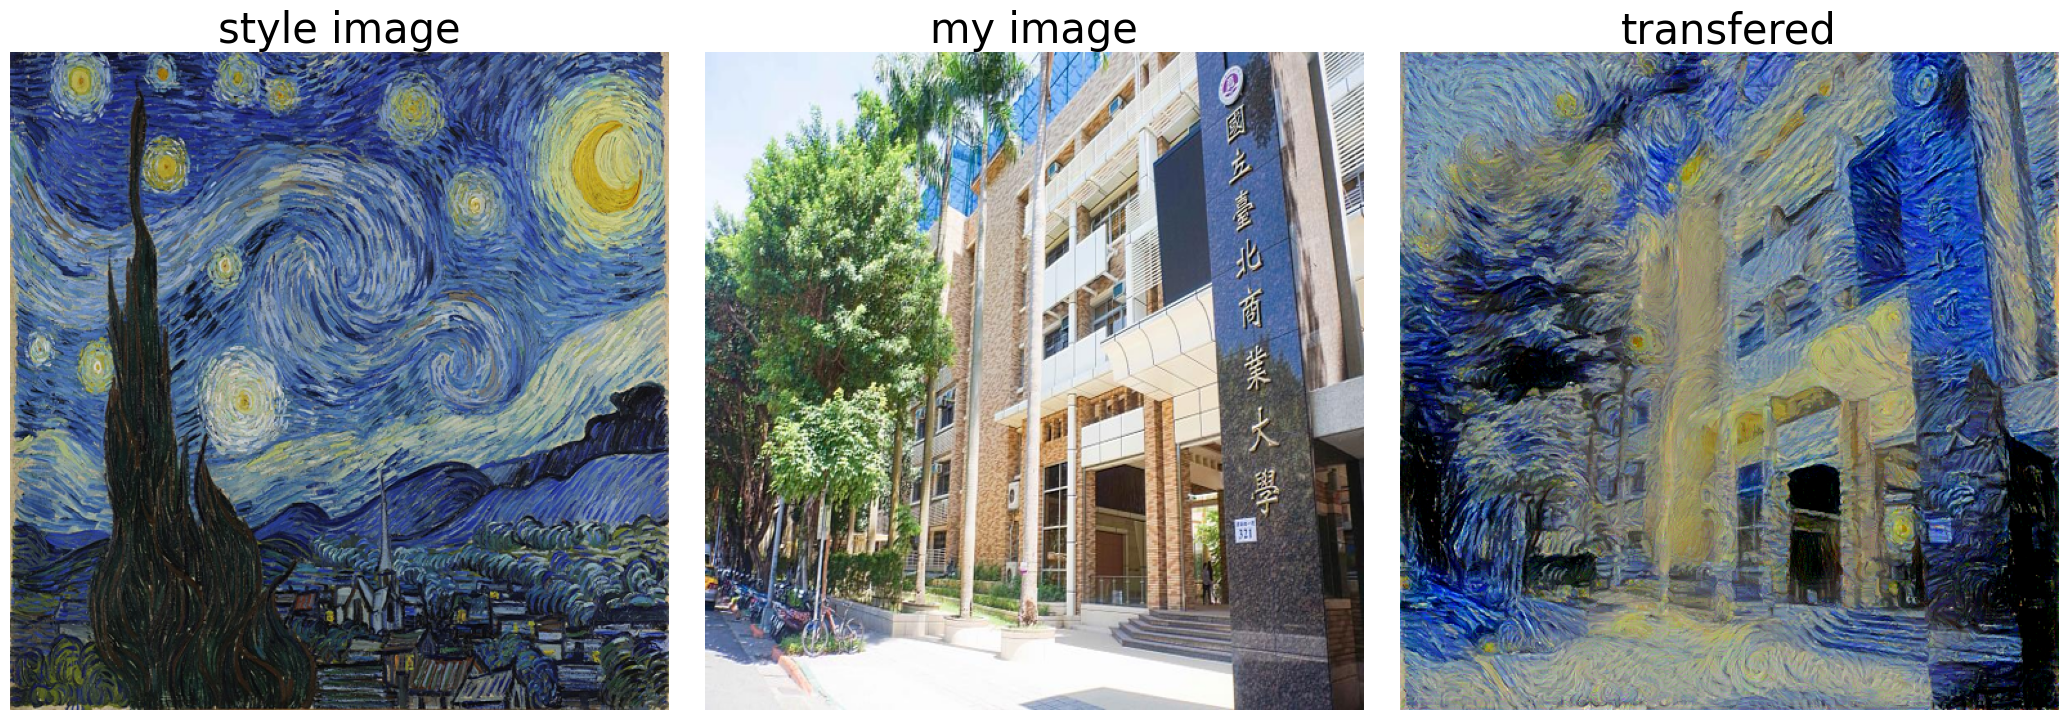

In [14]:
with torch.no_grad():
    output_img = postprocess(opt_img[0]).permute(1,2,0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(21,7))
simple_show(imgs[0], ax=ax[0], title='style image', fontdict={'fontsize': 30})
simple_show(imgs[1], ax=ax[1], title='my image', fontdict={'fontsize': 30})
simple_show(output_img, ax=ax[2], title='transfered', fontdict={'fontsize': 30})
plt.tight_layout()
plt.show()

In [15]:
output_img = output_img.cpu().detach().numpy().copy()
Image.fromarray(np.clip(output_img*255.0, 0, 255).astype(np.uint8)).save('11_5_transfered_output.jpg')